In [1]:
#import functions
import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from utils import resize_percent, edge_detect, count_gray_levels, fill

In [2]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y

In [3]:
'''Cropping the images''' 

'- data_path: path to the folder with the images to crop'
'- data_save: path to the folder to save the cropped images'
'- x_start: a starting x coordinate to crop an image'
'- x_end: an ending x coordinate to crop an image'
'- y_start: a starting y coordinate to crop an image'
'- y_end: an ending y coordinate to crop an image'
'- color: indicate if the images to crop are colored'

def crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False):
    for image in os.listdir(data_path):
        image_name = os.fsdecode(image)
        if color:
            img_next = cv.imread(data_path+f'{image_name}', cv.IMREAD_COLOR)
            cropped_img = img_next[x_start : x_end, y_start : y_end, :]
            cv.imwrite(data_save + f'{image_name}', cropped_img)
        else:
            img_next = cv.imread(data_path+f'{image_name}', cv.IMREAD_GRAYSCALE)
            cropped_img = img_next[x_start : x_end, y_start : y_end]
            cv.imwrite(data_save + f'{image_name}', cropped_img)

In [ ]:
# #ONLY RUN ONCE
# #making folders
# os.mkdir('sim_2perc')
# os.mkdir('sim_2perc_crop')

In [12]:
# #ONLY RUN ONCE
# #extracting frames from the simulated 2 percent G1100 video
video_name = 'test2percent_G1100_cut'
path_to_source = 'data/' + video_name + '.avi'
cap = cv.VideoCapture(path_to_source)
num_frames = 50
l=0
m=0
while l <= num_frames:
    ret, frame = cap.read()
    if not ret: 
        print('No frames grabbed!')
        break
    cv.imwrite(f'sim_2perc/{m}.jpg', frame)
    l+=1
    m+=1

No frames grabbed!


[ WARN:0@1928.693] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1928.693] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




In [13]:
# #ONLY RUN ONCE
# # crop images for faster calculation 
# data_path = 'sim_2perc/'
# data_save = 'sim_2perc_crop/'
# data_path = 'sim_1perc/'
# data_save = 'sim_1perc_crop/'
# data_path = 'sim_05perc/'
# data_save = 'sim_05perc_crop/'

x_start = 0
x_end = 120
y_start = 0
y_end = 30
crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

In [4]:
# thresholding the cross correlation image
def thresh_xcorr (image, T):
    image[image<T] = 0
    image[image>T] = 1
    return image

In [5]:
def apply_blurring(img, kernel_size, sigma_x):
    return cv.GaussianBlur(src=img.copy(), ksize=(kernel_size, kernel_size), sigmaX=sigma_x)

In [6]:
def apply_in_range_threshold(img, lower_bound, upper_bound):
    return cv.inRange(src=img.copy(), lowerb=lower_bound, upperb=upper_bound)

In [225]:
angle = 3
def slope_detect(T, GRAY_LEVEL_01, frNum, path_to_images, pixel, kernel):
    global angle
    _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
    image_xcorr = np.copy(corr_full_y)
    image = thresh_xcorr (image_xcorr, T)
    blur = apply_blurring(image, 7, 1)
    blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)
    img_th = apply_in_range_threshold(blur_norm, 0, GRAY_LEVEL_01)
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(img_th, None, None, None, 8, cv.CV_32S)
    areas = stats[1:, cv.CC_STAT_AREA]
    area_max1_idx = np.argmax(areas)
    area_max2_idx = np.argmax(np.delete(areas, area_max1_idx))
    img_emb = np.zeros((labels.shape), np.uint8)
    img_emb[labels == area_max1_idx + 1] = 255
    WHITE_LEVEL = 255
    img_ed = cv.Canny(image=img_emb, threshold1=WHITE_LEVEL//2, threshold2=WHITE_LEVEL, apertureSize=3, L2gradient=True)
    img_bl = apply_blurring(img_ed, 7, 1)
    img_line = img_bl
    lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=40, minLineLength=40, maxLineGap=10) #2percent
    # lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=25, minLineLength=10, maxLineGap=5) #1percent
    # lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=25, minLineLength=10, maxLineGap=5) #05percent


    points = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if 0 <= 180*np.arctan2(abs(y2-y1), abs(x2-x1))/np.pi <= 360:
                points = [x1, y1, x2, y2]
                cv.line(img_line, (x1, y1), (x2, y2), (255, 0, 0), 3)
                break
        angle = 180*np.arctan2(abs(y2-y1), abs(x2-x1))/np.pi
    return angle

In [226]:
frNum = 20
path_to_images = 'sim_2perc_crop/'
# path_to_images = 'sim_1perc_crop/'
# path_to_images = 'sim_05perc_crop/'

kernel = 1
threshold_bin = 0
image_1 = cv.imread(path_to_images + '0.jpg', cv.IMREAD_GRAYSCALE)
slopes = np.zeros([image_1.shape[0], image_1.shape[1]])  # empty matrix of 100x100

T = 200 #2 percent
# T = 150 #1 percent
# T = 130 #05 percent
GRAY_LEVEL_01 = 100

for i in range(image_1.shape[0]):
    for j in range(image_1.shape[1]):
        pixel=[i, j]
        #print(pixel)
        try:
            angle = slope_detect(T, GRAY_LEVEL_01, frNum, path_to_images, pixel, kernel)
        except ValueError:
            angle = None
        slopes[i, j] = angle
        print(pixel, angle)

[0, 0] 69.8293465881496
[0, 1] 71.24134965215777
[0, 2] 71.56505117707799
[0, 3] 72.58202920779716
[0, 4] 70.20112364547508
[0, 5] 71.24134965215777
[0, 6] 74.32047587758075
[0, 7] 73.49563861824498
[0, 8] 74.47588900324574
[0, 9] 71.56505117707799
[0, 10] 72.75854060106002
[0, 11] 70.27772223555296
[0, 12] 77.15229514128234
[0, 13] 70.86635679409453
[0, 14] 69.92847413546127
[0, 15] 72.82409638425325
[0, 16] 72.47443162627714
[0, 17] 71.87813975209865
[0, 18] 71.25865955480728
[0, 19] 74.05460409907715
[0, 20] 73.20162821869471
[0, 21] 74.32047587758075
[0, 22] 71.86191784440268
[0, 23] 72.75854060106002
[0, 24] 73.30075576600638
[0, 25] 71.86191784440268
[0, 26] 74.57783868126133
[0, 27] 73.66395711028154
[0, 28] 74.32047587758075
[0, 29] 70.49755149333778
[0, 30] 75.96375653207353
[0, 31] 73.20162821869471
[0, 32] 74.57783868126133
[0, 33] 71.89623696549337
[0, 34] 75.49983323344743
[0, 35] 74.18080605249986
[0, 36] 72.14968169778317
[0, 37] 75.7354877019201
[0, 38] 76.2005146039806

In [227]:
# saving the array to not run the same thing again
slope_folder = 'calculated_slopes/'
video_name = '2percent_simulation'
np.savetxt(slope_folder+video_name+'.csv', slopes, delimiter=",")

In [192]:
# loading the saved array back
with open(slope_folder+video_name+'.csv') as file_name:
    array = np.loadtxt(file_name, delimiter=",")

print(array)
print(type(array))

[[83.65980825 70.64100582 70.64100582 ... 56.76828893 56.30993247
  56.30993247]
 [83.65980825 70.64100582 70.64100582 ... 56.76828893 56.30993247
  56.30993247]
 [83.65980825 70.64100582 70.64100582 ... 56.76828893 56.30993247
  56.30993247]
 ...
 [83.65980825 70.64100582 70.64100582 ... 56.76828893 56.30993247
  56.30993247]
 [83.65980825 70.64100582 70.64100582 ... 56.76828893 56.30993247
  56.30993247]
 [83.65980825 70.64100582 70.64100582 ... 56.76828893 56.30993247
  56.30993247]]
<class 'numpy.ndarray'>


[[69.82934659 71.24134965 71.56505118 ... 74.0546041  64.59228189
  64.59228189]
 [69.82934659 71.24134965 71.56505118 ... 74.0546041  64.59228189
  64.59228189]
 [69.82934659 71.24134965 71.56505118 ... 74.0546041  64.59228189
  64.59228189]
 ...
 [69.82934659 71.24134965 71.56505118 ... 74.0546041  64.59228189
  64.59228189]
 [69.82934659 71.24134965 71.56505118 ... 74.0546041  64.59228189
  64.59228189]
 [69.82934659 71.24134965 71.56505118 ... 74.0546041  64.59228189
  64.59228189]]


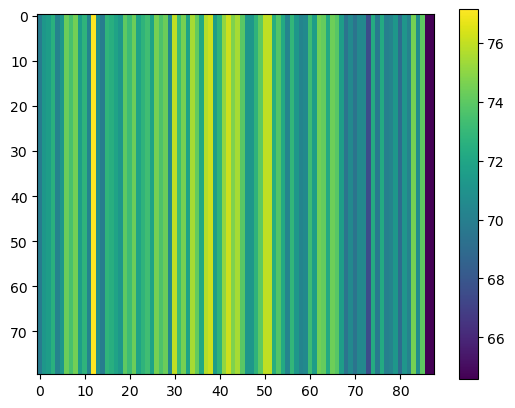

In [228]:
print(slopes)
plt.imshow(slopes)
plt.colorbar()

In [229]:
arr = np.argwhere(np.isnan(slopes))
print(arr)

[]


[[2.72222222 2.94444444 3.         ... 3.5        2.10526316 2.10526316]
 [2.72222222 2.94444444 3.         ... 3.5        2.10526316 2.10526316]
 [2.72222222 2.94444444 3.         ... 3.5        2.10526316 2.10526316]
 ...
 [2.72222222 2.94444444 3.         ... 3.5        2.10526316 2.10526316]
 [2.72222222 2.94444444 3.         ... 3.5        2.10526316 2.10526316]
 [2.72222222 2.94444444 3.         ... 3.5        2.10526316 2.10526316]]


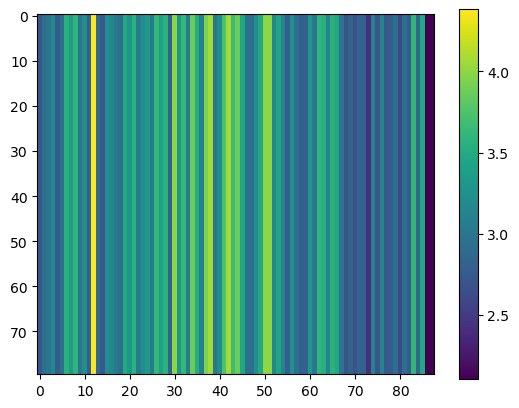

In [230]:
angle2slope = np.tan(np.pi*slopes/180)
print(angle2slope)
plt.imshow(angle2slope)
plt.colorbar()

[[2.72 2.94 3.   ... 3.5  2.11 2.11]
 [2.72 2.94 3.   ... 3.5  2.11 2.11]
 [2.72 2.94 3.   ... 3.5  2.11 2.11]
 ...
 [2.72 2.94 3.   ... 3.5  2.11 2.11]
 [2.72 2.94 3.   ... 3.5  2.11 2.11]
 [2.72 2.94 3.   ... 3.5  2.11 2.11]]


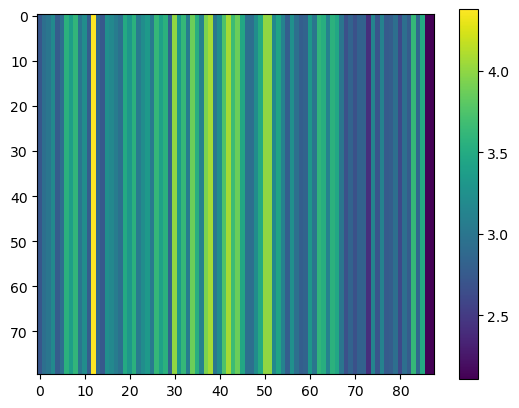

In [231]:
final_angle2slope = np.zeros((angle2slope.shape[0], angle2slope.shape[1]))
# for i in range(image_1.shape[0]):
#     for j in range(image_1.shape[1]):
#         final_angle2slope[i, j] = float("{:.2f}".format(angle2slope[i, j]))
final_angle2slope = np.round(angle2slope,2)
print(final_angle2slope)
plt.imshow(final_angle2slope)
plt.colorbar()

In [201]:
# calculate elasticity
def elasticity_HT (slope_value, density, conv_pix, conv_fr):
    conv_factor = (conv_pix * conv_fr)
    mu = ((slope_value * conv_factor)**2) * density
    return mu

In [202]:
# Compute elasticity
density = 1000
conv_pix = (1/2)*1e-6
conv_fr = 300000

mu = elasticity_HT(final_angle2slope, density, conv_pix, conv_fr) ##THIS SHIT ISNT WORKING
mu_2dec = np.round(mu,2)


[[270.92 270.92 270.92 ... 280.37 280.37 280.37]
 [280.37 280.37 280.37 ... 280.37 280.37 280.37]
 [280.37 280.37 280.37 ... 280.37 280.37 280.37]
 ...
 [280.37 280.37 280.37 ... 280.37 280.37 280.37]
 [280.37 280.37 280.37 ... 280.37 280.37 280.37]
 [280.37 280.37 280.37 ... 280.37 280.37 280.37]]


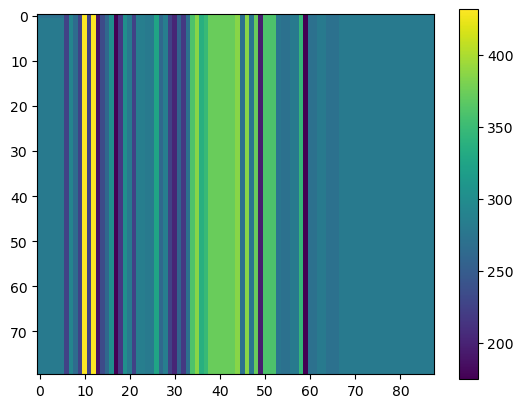

In [203]:
print(mu_2dec)
plt.imshow(mu_2dec)
plt.colorbar()